# Analysis for Brinjal price data in Odisha from 2012 to 2024 (District-Level)

- Code for the paper: https://arxiv.org/abs/2503.11690

In [42]:
# Import necessary libraries for the analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model

In [43]:
# Function to optimize EGARCH parameters
def optimize_egarch_parameters(data, p_range, o_range, q_range):
    best_aic = float('inf')
    best_params = None
    best_model = None

    for p in p_range:
        for o in o_range:
            for q in q_range:
                try:
                    model = arch_model(data, vol='EGARCH', p=p, o=o, q=q)
                    fit = model.fit(disp='off')
                    if fit.aic < best_aic:
                        best_aic = fit.aic
                        best_params = {'p': p, 'o': o, 'q': q}
                        best_model = fit
                except Exception as e:
                    print(f"Failed for p={p}, o={o}, q={q}: {e}")
                    continue

    return best_params, best_model

## Reading Price, Conditional Volatility and Meteorological Data

In [44]:
data = pd.read_csv("Price_Data/BRINJAL-MODALPRICE-MONTHLY.csv")
data["Price Date"] = pd.to_datetime(data["Price Date"], format="%d-%m-%Y") 

cond_vol = pd.read_csv("data\Brinjal-condvol-OD(state-level).csv")
cond_vol["Price Date"] = pd.to_datetime(cond_vol["Price Date"], format="%Y-%m-%d")

data.head()

<>:4: SyntaxWarning: invalid escape sequence '\B'
<>:4: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Abbin\AppData\Local\Temp\ipykernel_11312\4030546577.py:4: SyntaxWarning: invalid escape sequence '\B'
  cond_vol = pd.read_csv("data\Brinjal-condvol-OD(state-level).csv")


,Price Date,Balasore,Bargarh,Dhenkanal,Ganjam,Kalahandi,Nayagarh
0,2012-01-01,1400.0,966.666667,1250.0,1385.0,1000.0,1475.0
1,2012-02-01,900.0,800.000000,1000.0,1425.0,1800.0,1500.0
2,2012-03-01,600.0,1083.333333,1650.0,925.0,1850.0,825.0
3,2012-04-01,1200.0,875.000000,1000.0,950.0,1250.0,1000.0
4,2012-05-01,1700.0,800.000000,1000.0,1250.0,2000.0,1275.0


In [45]:
prec_data = pd.read_csv("Met_Data/Odisha-Prec-Data.csv")
prec_data['Price Date'] = pd.to_datetime(prec_data['Price Date'], format="%d-%m-%Y")

prec_data.head()

,Price Date,Balasore,Bargarh,Dhenkanal,Ganjam,Kalahandi,Nayagarh
0,2012-01-01,79.38,43.01,50.89,24.82,20.59,30.42
1,2012-02-01,5.35,6.77,3.89,0.44,1.18,1.16
2,2012-03-01,1.70,0.52,0.77,0.03,0.89,0.04
3,2012-04-01,104.62,38.17,74.70,74.84,64.66,76.04
4,2012-05-01,29.39,4.23,17.15,53.14,48.28,34.92


In [46]:
tmax_data = pd.read_csv("Met_Data/Odisha-Tmax-Data.csv")
tmax_data['Price Date'] = pd.to_datetime(tmax_data['Price Date'], format="%d-%m-%Y")

tmax_data.head()

,Price Date,Balasore,Bargarh,Dhenkanal,Ganjam,Kalahandi,Nayagarh
0,2012-01-01,30.36,28.22,29.78,29.51,30.98,30.37
1,2012-02-01,35.48,35.94,37.37,34.93,36.99,37.09
2,2012-03-01,40.18,40.23,41.26,37.15,40.58,40.30
3,2012-04-01,39.70,42.63,42.51,38.26,42.81,41.59
4,2012-05-01,41.19,46.19,44.35,38.19,44.82,42.47


## Exploratory Data Analysis and Visualization

In [47]:
df_logreturns = pd.DataFrame()
df_logreturns["Price Date"] = data["Price Date"]

# Log Returns of modal price for each district
for district in data.columns[1:]:
    df_logreturns[district] = np.log(data[district]) - np.log(data[district].shift(1))

df_logreturns = df_logreturns.dropna()
df_logreturns.head()

,Price Date,Balasore,Bargarh,Dhenkanal,Ganjam,Kalahandi,Nayagarh
1,2012-02-01,-0.441833,-0.189242,-0.223144,0.028472,0.587787,0.016807
2,2012-03-01,-0.405465,0.303186,0.500775,-0.432133,0.027399,-0.597837
3,2012-04-01,0.693147,-0.213574,-0.500775,0.026668,-0.392042,0.192372
4,2012-05-01,0.348307,-0.089612,0.000000,0.274437,0.470004,0.242946
5,2012-06-01,0.567984,1.216395,1.098612,0.631272,0.095310,0.702903


In [48]:
df_condvol = pd.DataFrame()
df_condvol["Price Date"] = data["Price Date"]

optimized_params = {}

# Optimize EGARCH parameters and fit the model for each district
for district in df_logreturns.columns[1:]:
    print(f"Optimizing EGARCH and fitting for {district}...")
    params, _ = optimize_egarch_parameters(df_logreturns[district], p_range=range(1, 5), o_range=range(0, 2), q_range=range(1, 5))
    model = arch_model(df_logreturns[district], vol='EGARCH', p=params['p'], o=params['o'], q=params['q'])
    fit = model.fit(disp='off')
    df_condvol[district] = fit.conditional_volatility

df_condvol = df_condvol.dropna(axis=0)
df_condvol.head()

c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Optimizing EGARCH and fitting for Balasore...


c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Optimizing EGARCH and fitting for Bargarh...
Optimizing EGARCH and fitting for Dhenkanal...


c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp 

Optimizing EGARCH and fitting for Ganjam...
Optimizing EGARCH and fitting for Kalahandi...


c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp 

Optimizing EGARCH and fitting for Nayagarh...


c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See sc

,Price Date,Balasore,Bargarh,Dhenkanal,Ganjam,Kalahandi,Nayagarh
1,2012-02-01,0.492146,0.471710,0.453884,0.428947,0.339730,0.404513
2,2012-03-01,0.525482,0.435846,0.503199,0.366694,0.258787,0.382945
3,2012-04-01,0.515982,0.464487,0.401509,0.444898,0.270615,0.381221
4,2012-05-01,0.453943,0.423542,0.469473,0.319645,0.303451,0.404134
5,2012-06-01,0.403962,0.403356,0.462629,0.441168,0.239497,0.584856


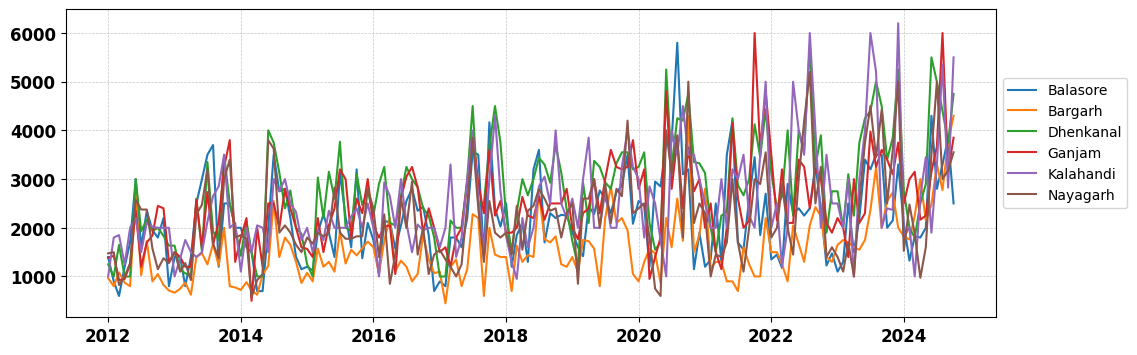

In [49]:
# Plotting the modal prices for each district

plt.figure(figsize=(12, 4))
for district in data.columns[1:]:
    plt.plot(data['Price Date'], data[district], label=district, linewidth=1.5)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.8))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

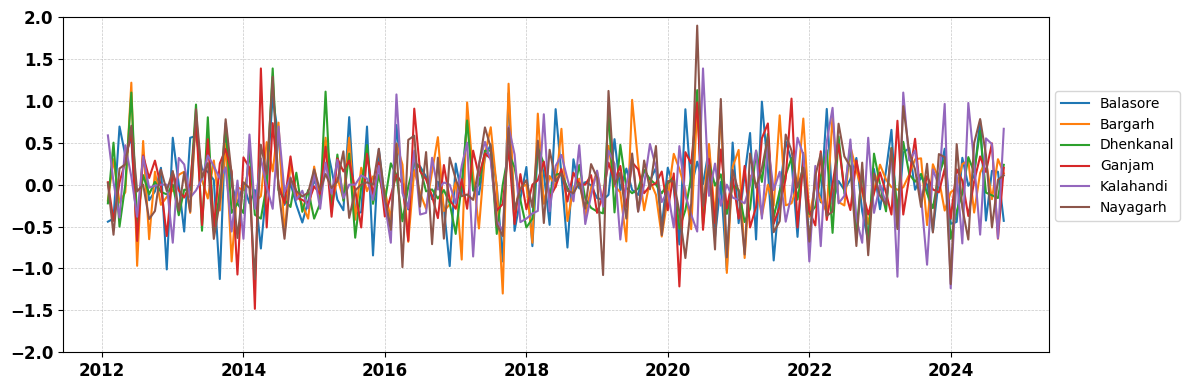

In [50]:
# Plotting the log returns for each district

plt.figure(figsize=(12, 4))

for district in df_logreturns.columns[1:]:
    plt.plot(df_logreturns["Price Date"], df_logreturns[district], label=district, linewidth=1.5)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(-2, 2)
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.8))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

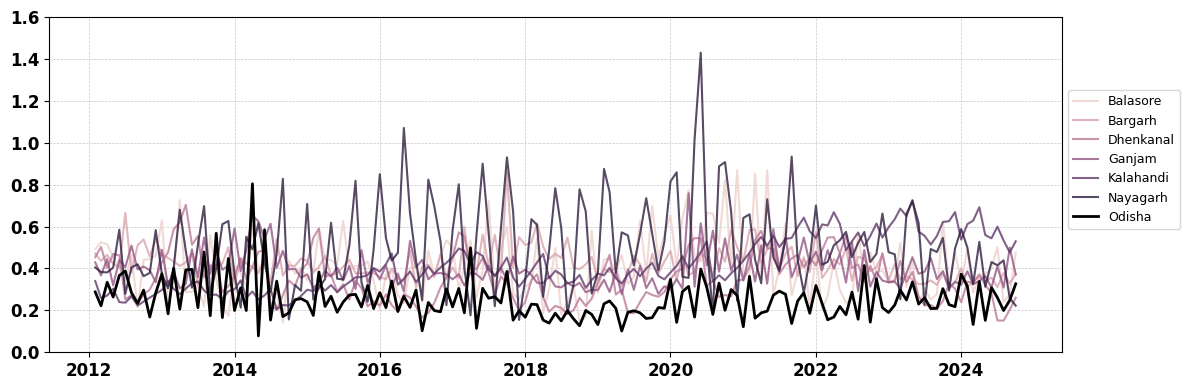

In [51]:
# Plotting the conditional volatilities for each district and Odisha state-level

palette = sns.cubehelix_palette(n_colors=6)

plt.figure(figsize=(12, 4))

for idx, district in enumerate(df_condvol.columns[1:]):
    plt.plot(df_condvol["Price Date"], df_condvol[district], label=district, linewidth=1.5, color=palette[idx], alpha=0.8)

plt.plot(cond_vol["Price Date"], cond_vol["condvol"], label="Odisha", linewidth=2, color="black")
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(0, 1.6)
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.8), fontsize=9)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Brinjal-condvol-Odisha-districtwise.png", dpi=600, bbox_inches='tight')
plt.show()